In [1]:
setwd("/import/home/share/zw/pql")
getwd()

set.seed(20240709)

library(RhpcBLASctl)
max_cores <- 36
blas_set_num_threads(max_cores)

library(doParallel)
library(foreach)

library(SPARK)
library(Matrix)
# library(Seurat)

library(ggplot2)

[1] "/import/home/share/zw/pql"

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”


In [2]:
DATA_PATH <- "/import/home/share/zw/pql/data/breast_cancer"
RESULT_PATH <- "/import/home/share/zw/pql/results/breast_cancer"

if (!dir.exists(DATA_PATH)) {
    dir.create(DATA_PATH)
}
if (!dir.exists(RESULT_PATH)) {
    dir.create(RESULT_PATH)
}

## 10X

In [3]:
seg_method <- "Cell_10X"

counts <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "counts.csv")
))
rownames(counts) <- counts[, 1]
counts[, 1] <- NULL
# head(counts)

coordinates <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "coordinates.csv")
))
rownames(coordinates) <- coordinates[, 1]
coordinates[, 1] <- NULL
# head(coordinates)

scvi_label <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "scvi_label.csv")
))
rownames(scvi_label) <- scvi_label[, 1]
scvi_label <- scvi_label[, 2]
# head(scvi_label)
all_celltypes <- unique(scvi_label)

New names:
• `` -> `...1`
Rows: 10000 Columns: 308
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (308): ...1, SFRP1, PCLAF, CDC42EP1, LGALSL, CCL5, USP53, IGF1, ESM1, MN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): ...1, x, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): celltype
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_type

In [4]:
pvalues_10X <- data.frame()
for(celltype_k in all_celltypes) {
    celltype_idx <- which(scvi_label == celltype_k)

    counts_k <- counts[celltype_idx, ]
    coordinates_k <- coordinates[celltype_idx, ]

    spark_obj <- CreateSPARKObject(
        counts = t(counts_k), location = coordinates_k
    )
    spark_obj@lib_size <- apply(spark_obj@counts, 2, sum)

    spark_obj <- spark.vc(spark_obj,
        covariates = NULL, lib_size = spark_obj@lib_size,
        num_core = max_cores, verbose = TRUE
    )
    spark_obj <- spark.test(spark_obj, check_positive = TRUE, verbose = TRUE)

    pvalues_10X <- rbind(
        pvalues_10X,
        data.frame(
            celltype = celltype_k,
            gene = rownames(spark_obj@res_mtest),
            pvalue = spark_obj@res_mtest[, "combined_pvalue"]
        )
    )
}

saveRDS(pvalues_10X, file.path(RESULT_PATH, seg_method, "pvalues_SPARK.rds"))

## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  460 
## number of total features:  162 
## number of adjusted covariates:  0 
# fitting count-based spatial model under the null hypothesis ... 
NO. Gene =  1 
NO. Gene =  2 
NO. Gene =  4 
NO. Gene =  3 
NO. Gene =  5 
NO. Gene =  6 
NO. Gene =  7 
NO. Gene =  8 
NO. Gene =  9 
NO. Gene =  10 
NO. Gene =  12 
NO. Gene =  11 
NO. Gene =  13 
NO. Gene =  14 
NO. Gene =  15 
NO. Gene =  16 
NO. Gene =  17 
NO. Gene =  18 
NO. Gene =  19 
NO. Gene =  20 
NO. Gene =  21 
NO. Gene =  22 
NO. Gene =  23 
NO. Gene =  24 
NO. Gene =  25 
NO. Gene =  26 
NO. Gene =  27 
NO. Gene =  28 
NO. Gene =  29 
NO. Gene =  30 
NO. Gene =  31 
NO. Gene =  32 
NO. Gene =  33 
NO. Gene =  34 
NO. Gene =  35 
NO. Gene =  36 
SPARK.CV::tau =  1 
 SPARK.CV::tau =  0.162481798442498 
SPARK.CV::tau =  1 
 SPARK.CV::tau =  0.541693284497248 
SPARK.CV::tau =  1 
 SPARK.CV::tau =  1.43367237724832 
NO. Gene =  40 
NO. Gene =  37 
NO. Gene =  38 
SP

In [5]:
# pvalues_10X <- readRDS(file.path(RESULT_PATH, seg_method, "pvalues_SPARK.rds"))
# pvalues_10X[pvalues_10X$celltype == "Stromal", ]

## UCS

In [6]:
seg_method <- "UCS_10X"

counts <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "counts.csv")
))
rownames(counts) <- counts[, 1]
counts[, 1] <- NULL
# head(counts)

coordinates <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "coordinates.csv")
))
rownames(coordinates) <- coordinates[, 1]
coordinates[, 1] <- NULL
# head(coordinates)

scvi_label <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "scvi_label.csv")
))
rownames(scvi_label) <- scvi_label[, 1]
scvi_label <- scvi_label[, 2]
# head(scvi_label)
all_celltypes <- unique(scvi_label)

New names:
• `` -> `...1`
Rows: 10000 Columns: 308
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (308): ...1, IL2RG, SNAI1, GLIPR1, OXTR, MYBPC1, MUC6, PDK4, KLRB1, RUNX...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): ...1, x, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): celltype
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_type

In [7]:
pvalues_UCS <- data.frame()
for(celltype_k in all_celltypes) {
    celltype_idx <- which(scvi_label == celltype_k)

    counts_k <- counts[celltype_idx, ]
    coordinates_k <- coordinates[celltype_idx, ]

    spark_obj <- CreateSPARKObject(
        counts = t(counts_k), location = coordinates_k
    )
    spark_obj@lib_size <- apply(spark_obj@counts, 2, sum)

    spark_obj <- spark.vc(spark_obj,
        covariates = NULL, lib_size = spark_obj@lib_size,
        num_core = max_cores, verbose = TRUE
    )
    spark_obj <- spark.test(spark_obj, check_positive = TRUE, verbose = TRUE)

    pvalues_UCS <- rbind(
        pvalues_UCS,
        data.frame(
            celltype = celltype_k,
            gene = rownames(spark_obj@res_mtest),
            pvalue = spark_obj@res_mtest[, "combined_pvalue"]
        )
    )
}

saveRDS(pvalues_UCS, file.path(RESULT_PATH, seg_method, "pvalues_SPARK.rds"))

## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  368 
## number of total features:  126 
## number of adjusted covariates:  0 
# fitting count-based spatial model under the null hypothesis ... 
NO. Gene =  1 
NO. Gene =  2 
NO. Gene =  3 
NO. Gene =  4 
NO. Gene =  5 
NO. Gene =  6 
NO. Gene =  7 
NO. Gene =  8 
NO. Gene =  9 
NO. Gene =  10 
NO. Gene =  11 
NO. Gene =  12 
NO. Gene =  13 
NO. Gene =  14 
NO. Gene =  15 
NO. Gene =  16 
NO. Gene =  17 
NO. Gene =  18 
NO. Gene =  19 
NO. Gene =  20 
NO. Gene =  21 
NO. Gene =  22 
NO. Gene =  23 
SPARK.CV::tau =  1 
 SPARK.CV::tau =  0.889797576429071 
NO. Gene =  37 
NO. Gene =  24 
NO. Gene =  25 
NO. Gene =  26 
SPARK.CV::tau =  1 
 SPARK.CV::tau =  0.173043006914362 
NO. Gene =  27 
NO. Gene =  39 
NO. Gene =  28 
NO. Gene =  29 
SPARK.CV::tau =  1 
 SPARK.CV::tau =  0.0808809887942406 
SPARK.CV::tau =  1 
 SPARK.CV::tau =  0.182257456260794 
NO. Gene =  30 
NO. Gene =  38 
NO. Gene =  41 
SPARK.CV::tau =  1 
 SP

## Plot

In [3]:
pvalues_10X <- readRDS(
    file = file.path(
        RESULT_PATH, "Cell_10X", "pvalues_SPARK.rds"
    )
)
pvalues_UCS <- readRDS(
    file = file.path(
        RESULT_PATH, "UCS_10X", "pvalues_SPARK.rds"
    )
)

In [4]:
pvalues_all <- merge(
    pvalues_10X,
    pvalues_UCS,
    by = c("celltype", "gene"),
    suffixes = c("_10X", "_UCS")
)
dim(pvalues_all)
head(pvalues_all)

[1] 2310    4

celltype gene    pvalue_10X pvalue_UCS
1 B Cells  ACTA2   0.1322722  0.49954764
2 B Cells  ACTG2   0.1676816  0.01158277
3 B Cells  ADAM9   0.5304303  0.48991858
4 B Cells  ADGRE5  0.1874401  0.64177169
5 B Cells  AIF1    0.4186312  0.10643992
6 B Cells  ANKRD28 0.5806893  0.56627327

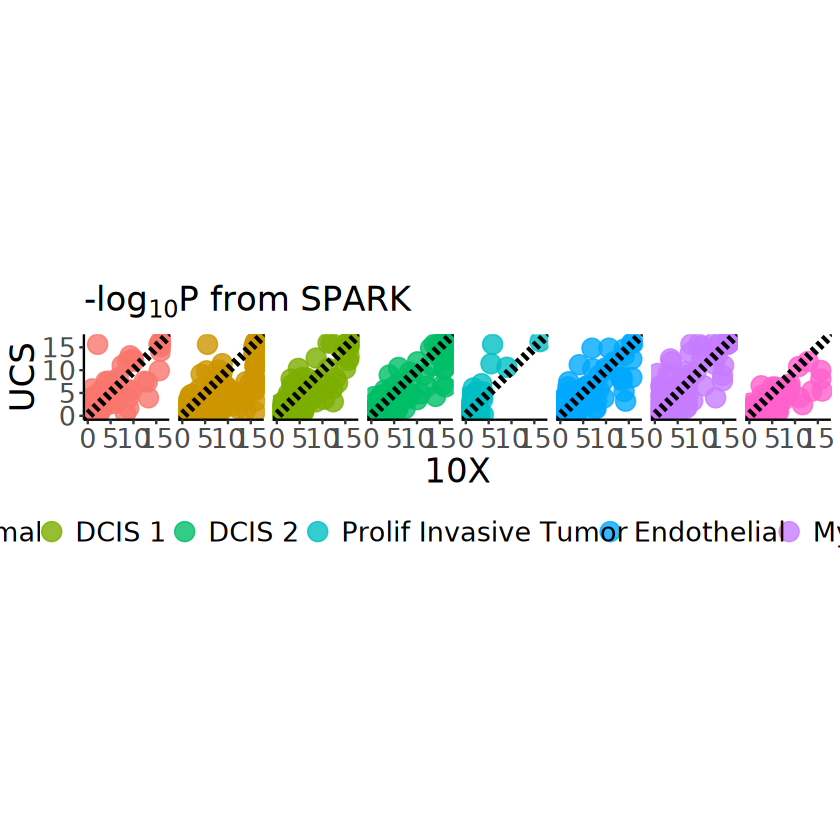

In [5]:
log10p_lim <- 17 # 5.55e-17

# major_celltypes <- c("Invasive Tumor", "Stromal", "DCIS 1", "DCIS 2", "Prolif Invasive Tumor", "Endothelial", "Myoepi ACTA2+", "Myoepi KRT15+")
major_celltypes <- c("Invasive Tumor", "Stromal", "DCIS 1", "DCIS 2", "Prolif Invasive Tumor", "Endothelial", "Myoepi ACTA2+", "Myoepi KRT15+")
pvalues_all_major_celltype <- pvalues_all[pvalues_all$celltype %in% major_celltypes, ]
pvalues_all_major_celltype$celltype <- factor(
    pvalues_all_major_celltype$celltype,
    levels = major_celltypes
)
# pvalues_all_major_celltype$pvalue_10X[
#     pvalues_all_major_celltype$pvalue_10X < 5.55e-17
# ] <- 5.55e-17
# pvalues_all_major_celltype$pvalue_UCS[
#     pvalues_all_major_celltype$pvalue_UCS < 5.55e-17
# ] <- 5.55e-17
p <- ggplot(
    # pvalues_all,
    pvalues_all_major_celltype,
    aes(x = -log10(pvalue_10X), y = -log10(pvalue_UCS))
) +
    geom_point(aes(color = celltype), size = 5, alpha = 0.8) +
        geom_abline(
            intercept = 0, slope = 1,
            linetype = "dashed", linewidth = 2
        ) +
    scale_x_continuous(limits = c(0, log10p_lim)) +
        scale_y_continuous(limits = c(0, log10p_lim)) +
        coord_fixed(ratio = 1) +
        facet_wrap(~celltype, nrow = 1) +
        theme_classic() +
        labs(
            x = "10X", y = "UCS",
            title = expression(paste("-log"[10], plain(P), " from SPARK"))
        )  + 
        guides(color = guide_legend(nrow = 1)) +
        theme(
            plot.title = element_text(size = 20),
            axis.title = element_text(size = 20),
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            strip.text = element_blank(),
            legend.title = element_blank(),
            legend.text = element_text(size = 16),
            legend.position = "bottom"
        )
    ggsave(
        filename = file.path(RESULT_PATH, "SPARK_seg_comparison.pdf"),
        plot = p,
        width = 18,
        height = 4
    )
    
      p

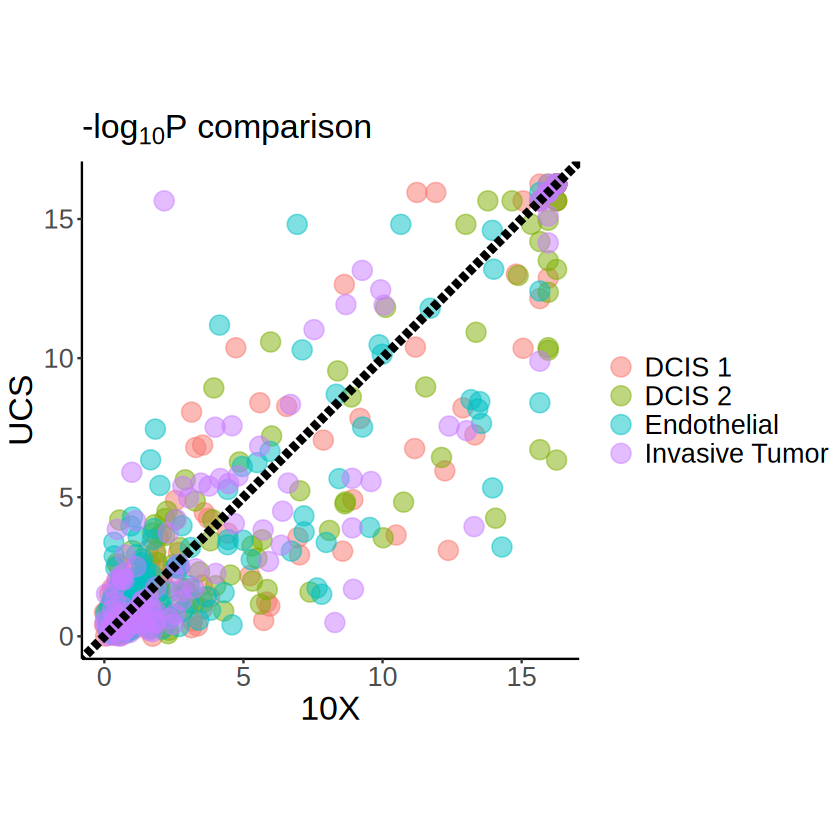

In [11]:
major_celltype <- c("DCIS 1", "DCIS 2", "Endothelial", "Invasive Tumor")
p <- ggplot(
    pvalues_all[pvalues_all$celltype %in% major_celltype, ],
    aes(x = -log10(pvalue_10X), y = -log10(pvalue_UCS))
) +
    geom_point(aes(color = celltype), size = 5, alpha = 0.5) +
    geom_abline(
        intercept = 0, slope = 1,
        linetype = "longdash", linewidth = 2
    ) +        

        coord_fixed(ratio = 1) +
        theme_classic() +
        labs(
            x = "10X", y = "UCS",
            title = expression(paste("-log"[10], plain(P), " comparison"))
        ) + 
        theme(
            plot.title = element_text(size = 20),
            axis.title = element_text(size = 20),
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            legend.title = element_blank(),
            legend.text = element_text(size = 16)
        )
    ggsave(
        filename = file.path(RESULT_PATH, "SPARK_seg_comparison_major_celltype.pdf"),
        plot = p,
        width = 8,
        height = 8
    )
    
      p